In [28]:
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.fft import rfft, irfft, rfftfreq

import analysis_utils as utils
import importlib

In [29]:
yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']

In [30]:
utils.load_plotting_setting()

In [31]:
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py'>

## Load 1 mbar data for plotting

In [72]:
data_1mbar = r'/Users/yuhan/work/nanospheres/data/20240904_all_1mbar/20240904_all_1mbar.mat'

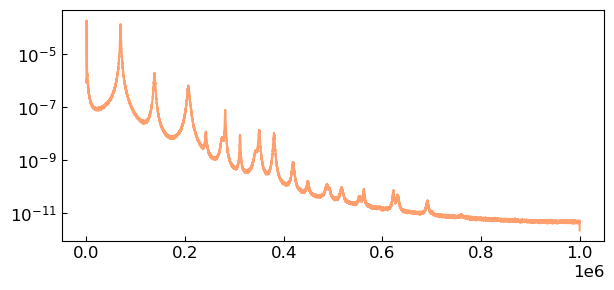

In [73]:
dtt, tt, nn = utils.load_timestreams(data_1mbar, ['D'])
zz = nn[0]
ffz_1mbar, ppz_1mbar = utils.get_psd(dt=dtt, zz=zz, nperseg=50000)

plt.plot(ffz_1mbar, ppz_1mbar)
plt.yscale('log')

## Load impulse calibration files

In [74]:
folder = r'/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/'
dataset = r'20240802_10v_4e-8mbar'

In [75]:
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

## Work out reconstruction for one pulse first

In [76]:
dtt, tt, nn = utils.load_timestreams(data_files[0], ['D', 'G'])

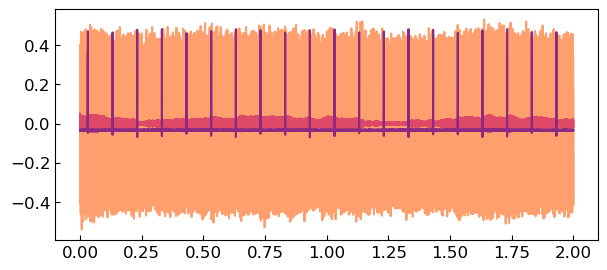

In [77]:
fs = int(np.ceil(1/dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

plt.plot(tt, zz)
plt.plot(tt, zz_bp)
plt.plot(tt, dd)

Fit PSD to get an initial value of omega and gamma

<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/709650542.py:21: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/709650542.py:22: SyntaxWarning: invalid escape sequence '\s'
  f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')


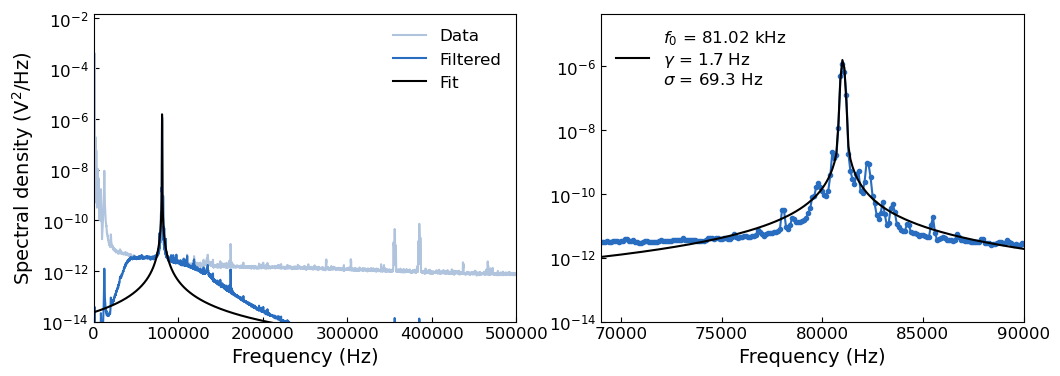

In [78]:
ffz, ppz = utils.get_psd(dt=dtt, zz=zz, nperseg=50000)
ffz_bp, ppz_bp = utils.get_psd(dt=dtt, zz=zz_bp, nperseg=50000)

# Fit with a voigt profile
popt = utils.fit_z_peak(ffz_bp, ppz_bp, utils.log_voigt, (69000, 90000), [1e-5, 79000*2*np.pi, 200, 100], False)
omega0, gamma = popt[1], popt[3]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(ffz, ppz, 'lightsteelblue', label='Data')
axes[0].plot(ffz_bp, ppz_bp, yale_colors[1], label='Filtered')
axes[0].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt)), 'k', label='Fit')
axes[0].set_yscale('log')
axes[0].set_xlim(0, 500000)
axes[0].set_ylim(1e-14)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Spectral density (V$^2$/Hz)')
axes[0].legend(frameon=False)

label = (f'$f_0$ = {popt[1]/(2*np.pi*1000):.2f} kHz\n'\
         f'$\gamma$ = {popt[3]/(2*np.pi):.1f} Hz\n'
         f'$\sigma$ = {popt[2]/(2*np.pi):.1f} Hz')
axes[1].plot(ffz_bp, ppz_bp, yale_colors[1], marker='.')
axes[1].plot(ffz, np.exp(utils.log_voigt(ffz*2*np.pi, *popt)), 'k', label=label)
axes[1].set_yscale('log')
axes[1].set_xlim(69000, 90000)
axes[1].set_ylim(1e-14)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].legend(frameon=False)

## Make a detection spectrum

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/3232909634.py:11: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')


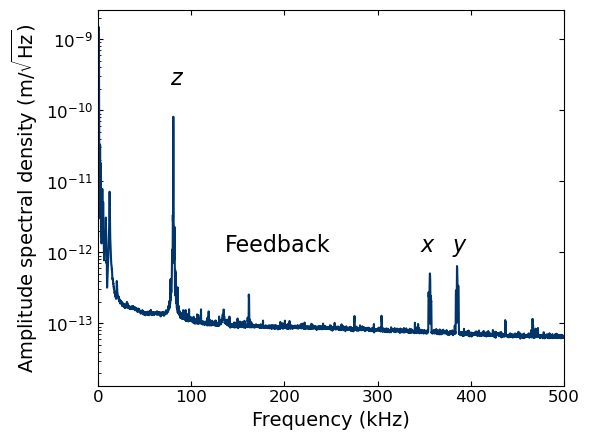

In [79]:
cal_factor = 160888032841252.19 * 1.1

fig, ax = plt.subplots(figsize=(6, 4.5))
ax.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)

ax.plot(ffz/1000, np.sqrt(ppz/cal_factor), color=yale_colors[0])
ax.set_yscale('log')
# ax.set_ylim(1e-27, 1e-18)
ax.set_xlim(0, 500)
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')

ax.text(77, np.sqrt(5e-20), '$z$', fontsize=16)
ax.text(68*2, np.sqrt(1e-24), 'Feedback', fontsize=16)
ax.text(345, np.sqrt(1e-24), '$x$', fontsize=16)
ax.text(380, np.sqrt(1e-24), '$y$', fontsize=16)

fig.tight_layout()
plt.savefig('/Users/yuhan/work/nanospheres/figures/detection_asd.png', format='png', transparent=True, dpi=600)

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/2054130645.py:12: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')


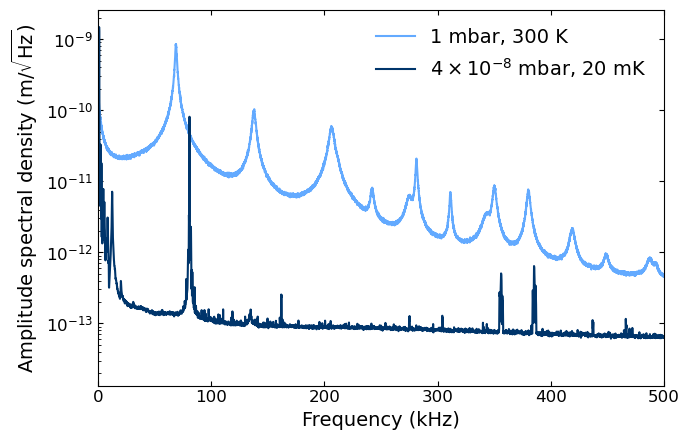

In [85]:
cal_factor = 160888032841252.19 * 1.1

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)

ax.plot(ffz_1mbar/1000, np.sqrt(ppz_1mbar/cal_factor), color='#63aaff', label='1 mbar, 300 K')
ax.plot(ffz/1000, np.sqrt(ppz/cal_factor), color=yale_colors[0], label='$4 \\times 10^{-8}$ mbar, 20 mK')
ax.set_yscale('log')
# ax.set_ylim(1e-27, 1e-18)
ax.set_xlim(0, 500)
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')
ax.legend(frameon=False, fontsize=14)

# ax.text(77, np.sqrt(5e-20), '$z$', fontsize=16)
# ax.text(68*2, np.sqrt(1e-24), 'Feedback', fontsize=16)
# ax.text(345, np.sqrt(1e-24), '$x$', fontsize=16)
# ax.text(380, np.sqrt(1e-24), '$y$', fontsize=16)

fig.tight_layout()
plt.savefig('/Users/yuhan/work/nanospheres/figures/detection_cooling_asd.png', format='png', transparent=True, dpi=600)

Find the position of the appied impulses

In [38]:
trigger_val = 0.4
pulse_idx = utils.get_pulse_idx(dd, trigger_val)

Try reconstruction with fitting for transfer function before the pulse. Get the 9th pulse in the file.

In [39]:
window = utils.get_analysis_window(tt, pulse_idx[8], 10000)
prepulse_window = utils.get_prepulse_window(tt, pulse_idx[8], 2500)

In [40]:
zzk = rfft(zz_bp[prepulse_window])
ff = rfftfreq(zz_bp[prepulse_window].size, dtt)
pp = np.abs(zzk)**2 / (zz_bp[prepulse_window].size / dtt)

In [41]:
psd_fit_scaling = 1e10  # scaling factor to avoid numerical error in lorentzian fit
amp_fit, omega0_fit, gamma_fit = utils.fit_lorentzian(ff, pp*psd_fit_scaling, (20000, 300000))

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.47056e-32): result may not be accurate.
  x = solve(aa, bb)


<>:10: SyntaxWarning: invalid escape sequence '\g'
<>:10: SyntaxWarning: invalid escape sequence '\g'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/2969318359.py:10: SyntaxWarning: invalid escape sequence '\g'
  f'$\gamma$ = {gamma_fit/(2*np.pi):.1f} Hz')


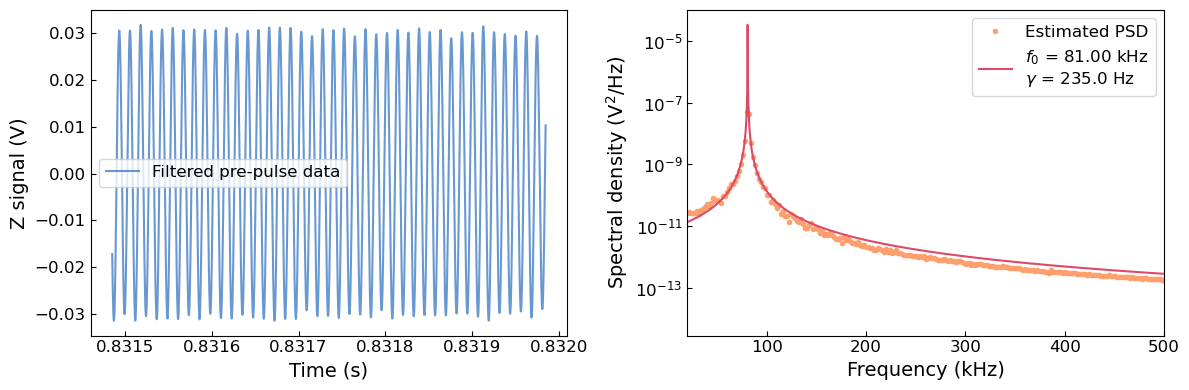

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(tt[prepulse_window], zz_bp[prepulse_window], label='Filtered pre-pulse data', color=yale_colors[1], alpha=0.7)
axes[0].legend()
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Z signal (V)')

ff_plot = np.linspace(ff[0], ff[-1], 20000)
label = (f'$f_0$ = {omega0_fit/(2*np.pi*1000):.2f} kHz\n'\
         f'$\gamma$ = {gamma_fit/(2*np.pi):.1f} Hz')
axes[1].plot(ff/1000, pp, '.', label='Estimated PSD')
axes[1].plot(ff_plot/1000, utils.lorentzian_for_fitting(ff_plot*2*np.pi, amp_fit/psd_fit_scaling, omega0_fit, gamma_fit), label=label)
axes[1].set_yscale('log')
# axes[1].set_ylim(1e-12)
axes[1].set_xlim(20, 500)
axes[1].set_xlabel('Frequency (kHz)')
axes[1].set_ylabel('Spectral density (V$^2$/Hz)')
axes[1].legend()

fig.tight_layout()

In [44]:
amp = utils.get_pulse_amp(dtt, zz_bp[window], omega0_fit, 20*2*np.pi)
amp_lp = utils.lowpass_filtered(amp, fs, 120000, 3)

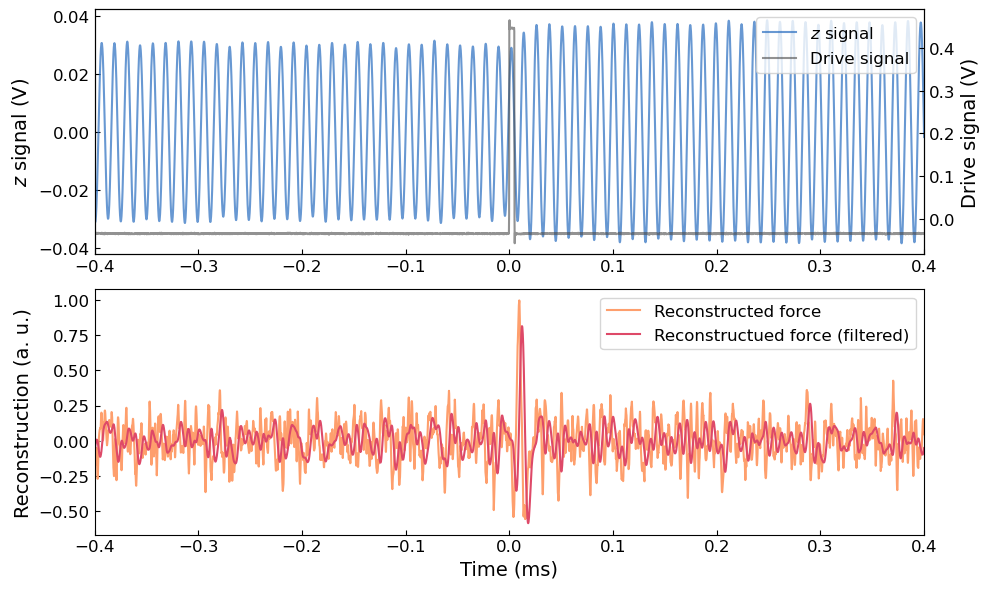

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

ax0_twinx = axes[0].twinx()
sig0 = axes[0].plot((tt[window]-tt[pulse_idx[8]])*1e3, zz_bp[window], color=yale_colors[1], alpha=0.7, label='$z$ signal')
sig1 = ax0_twinx.plot((tt[window]-tt[pulse_idx[8]])*1e3, dd[window], color=yale_colors[3], alpha=0.6, label='Drive signal')
labs = [s.get_label() for s in (sig0+sig1)]

axes[0].set_ylabel('$z$ signal (V)')
ax0_twinx.set_ylabel('Drive signal (V)')
axes[0].legend((sig0+sig1), labs, fontsize=12, loc='upper right')

axes[1].plot((tt[window][100:-100]-tt[pulse_idx[8]])*1e3, amp[100:-100]/1e9, label='Reconstructed force')
axes[1].plot((tt[window][100:-100]-tt[pulse_idx[8]])*1e3, amp_lp[100:-100]/1e9, label='Reconstructued force (filtered)')
axes[1].set_ylabel('Reconstruction (a. u.)')
axes[1].set_xlabel('Time (ms)')
axes[1].legend(fontsize=12, loc='upper right')

for ax in axes:
    ax.set_xlim(-0.4, 0.4)
    
fig.tight_layout()

In [46]:
def load_multiple_pulses(idxs, dtt, tt, zz_bp, dd):
    
    windows, amps, amp_lps = [], [], []
    for i, idx in enumerate(idxs):
        window, amp, amp_lp, _ = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, False)
        windows.append(window)
        amps.append(amp)
        amp_lps.append(amp_lp)
        
    return np.asarray(windows), np.asarray(amps), np.asarray(amp_lps)

In [47]:
indices = [pulse_idx[6], pulse_idx[9]]
windows, amps, amp_lps = load_multiple_pulses(indices, dtt, tt, zz_bp, dd)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.14762e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.9683e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:145: RuntimeWarning: invalid value encountered in sqrt
  gamma  = np.sqrt(x[2] / x[0] - omega0**2)


<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_15771/2232786488.py:26: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)', fontsize=18)


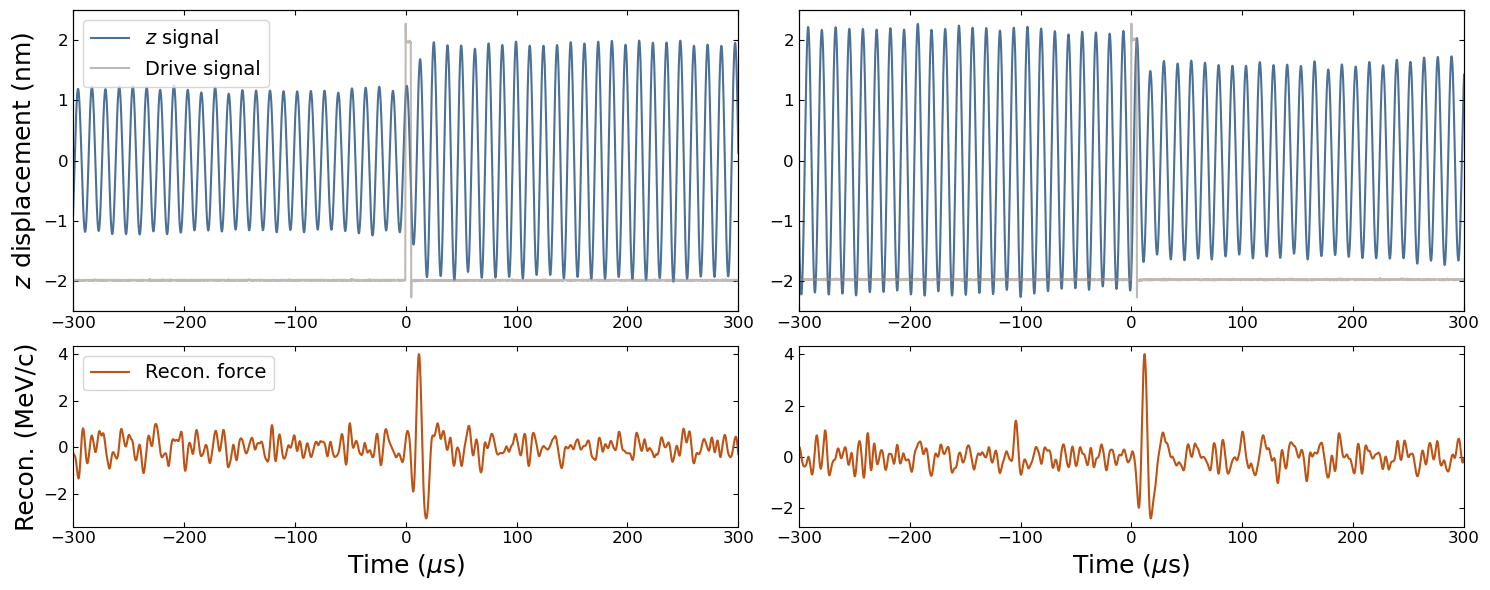

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), height_ratios=[5, 3])

for i, ax in enumerate(axes.T):
    window, amp, amp_lp, idx = windows[i], amps[i], amp_lps[i], indices[i]
    
    ax0_twinx = ax[0].twinx()
    sig0 = ax[0].plot((tt[window]-tt[idx])*1e6, zz_bp[window]/np.sqrt(cal_factor)*1e9, alpha=0.7, label='$z$ signal', color='#00356b')
    sig1 = ax0_twinx.plot((tt[window]-tt[idx])*1e6, dd[window], alpha=0.6, label='Drive signal', color='#978d85')
    ax0_twinx.set_yticks([])
    labs = [s.get_label() for s in (sig0+sig1)]
    
    ax[1].plot((tt[window][100:-100]-tt[idx])*1e6, 4*amp_lp[100:-100]/1e9/(np.max(amp_lp[100:-100]/1e9)), label='Recon. force', color='#bd5314')
#     ax[1].plot((tt[window][100:-100]-tt[idx])*1e3, amp_lp[100:-100]/1e9, label='Filtered')
    
    if i == 0:
        ax[0].legend((sig0+sig1), labs, fontsize=14, loc='upper left')
        ax[1].legend(fontsize=14, loc='upper left')
        ax[0].set_ylabel('$z$ displacement (nm)', fontsize=18)
        ax[1].set_ylabel('Recon. (MeV/c)', fontsize=18)
        
for ax in axes.flatten():
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False,rotation=0)
for ax in axes[0]:
    ax.set_ylim(-2.5, 2.5)
for ax in axes[1]:
    ax.set_xlabel('Time ($\mu$s)', fontsize=18)
#     ax.set_ylim(-0.8, 1)
for ax in axes.flatten():
    ax.set_xlim(-300, 300)
    
fig.tight_layout()
plt.savefig('/Users/yuhan/work/nanospheres/figures/example_calibration_pulses.png', format='png', transparent=True, dpi=600)

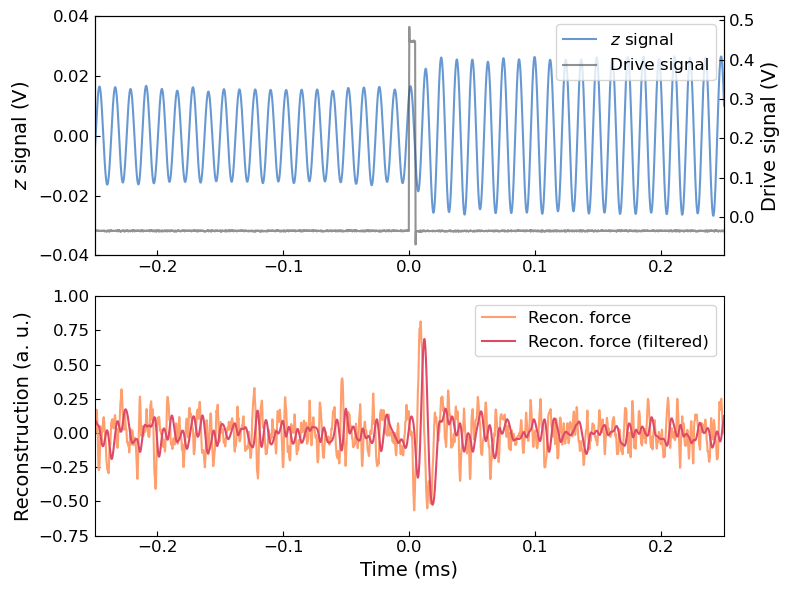

In [72]:
idx = pulse_idx[6]
_, _, _, _ = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, True, 'example_pulse_0.png')

## Run reconstruction on all pulses

In [5]:
folder = r'/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/'
dataset = r'20240802_5v_4e-8mbar'

In [6]:
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

In [7]:
data_files

['/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0001/20240802-0001_4.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0001/20240802-0001_1.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0001/20240802-0001_2.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0001/20240802-0001_3.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0005/20240802-0005_3.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0005/20240802-0005_2.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0005/20240802-0005_1.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_5v_4e-8mbar/20240802-0005/20240802-0005_4.mat',
 '/Users/yuhan/work/nanospheres/data/20240802_pl

In [57]:
file = data_files[7]
dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
fs = int(np.ceil(1/dtt))

zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)

In [58]:
trigger_val = 0.2
pulse_idx = utils.get_pulse_idx(dd, trigger_val)

In [59]:
amps = np.empty(pulse_idx.size)
windows, fs, f_lps = [], [], []
for i, idx in enumerate(pulse_idx):
    window, f, f_lp, amps[i] = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, False, None)
    windows.append(window)
    fs.append(f)
    f_lps.append(f_lp)

/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.46106e-27): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.15641e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.36153e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.88972e-30): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.94633e-31): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

In [60]:
amps

array([0.52359469, 0.45491692, 0.45890225, 0.44281358, 0.50984711,
       0.60251777, 0.54135095, 0.53904031, 0.62467094, 0.75160041,
       0.69428049, 0.59291291, 0.44171083, 0.51621819, 0.51327553,
       0.51211089, 1.00353453, 0.55009199, 0.74039128, 0.66362674])

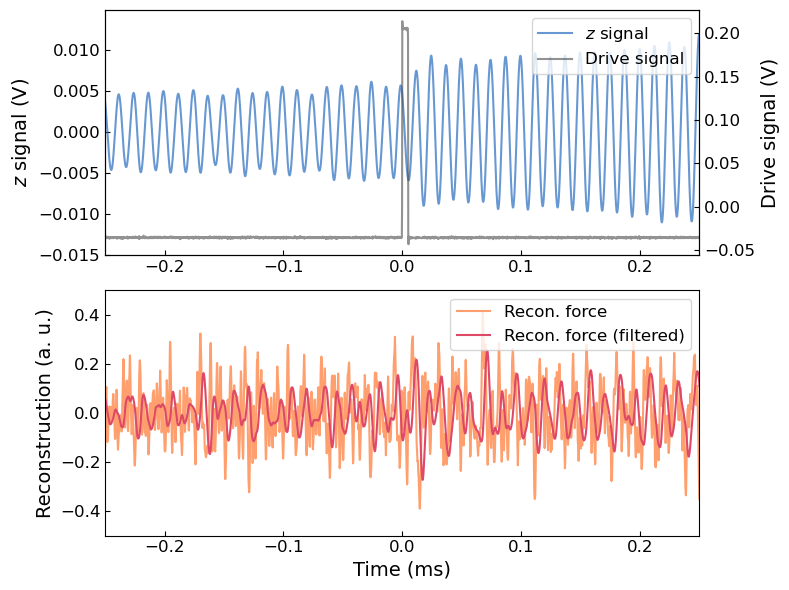

In [69]:
idx = pulse_idx[]
win, f, f_lp, amp_idx = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, True, None)

(-1.0, 1.0)

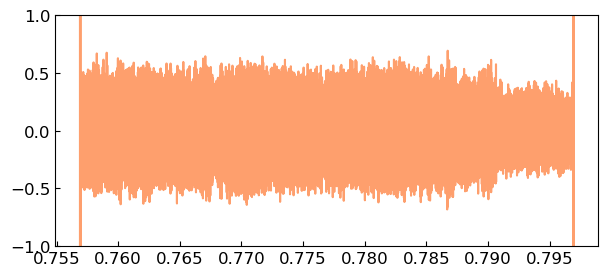

In [112]:
plt.plot(tt[window], f/1e9)
plt.ylim(-1, 1)

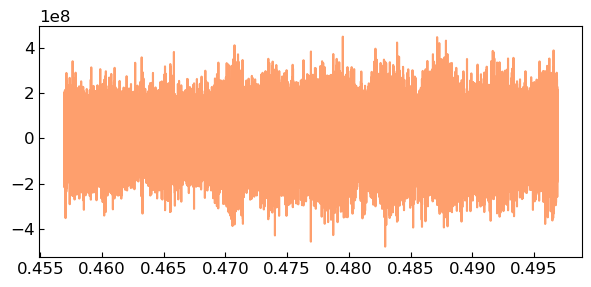

In [107]:
plt.plot(tt[win][100:-100], f[100:-100])
# plt.plot(tt[win], dd[win])

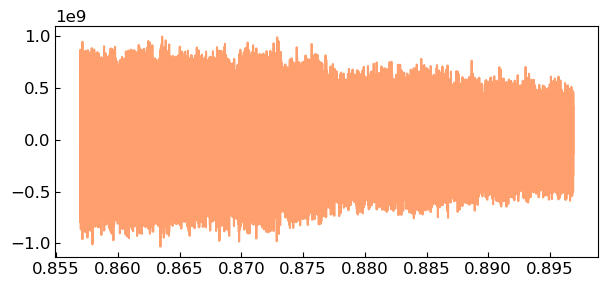

In [79]:
plt.plot(tt[win][100:-100], f[100:-100])

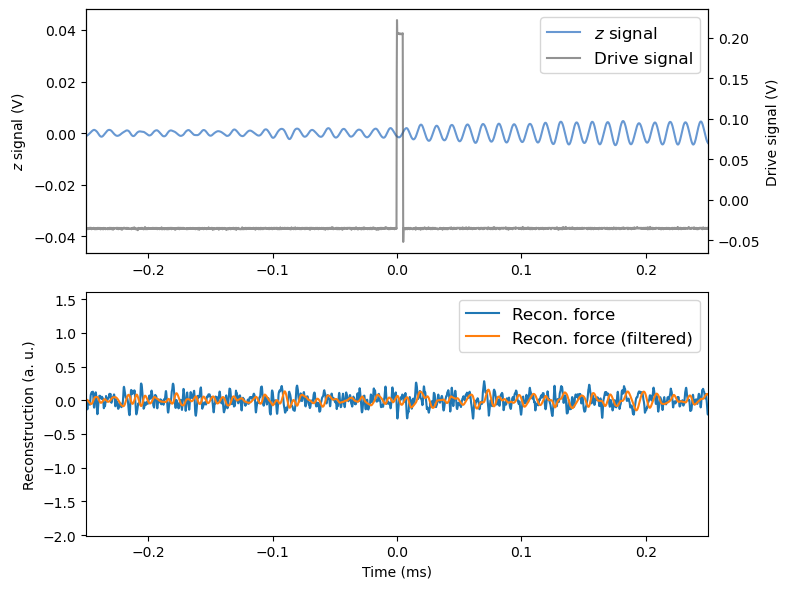

In [55]:
amp

1.8441951730138733

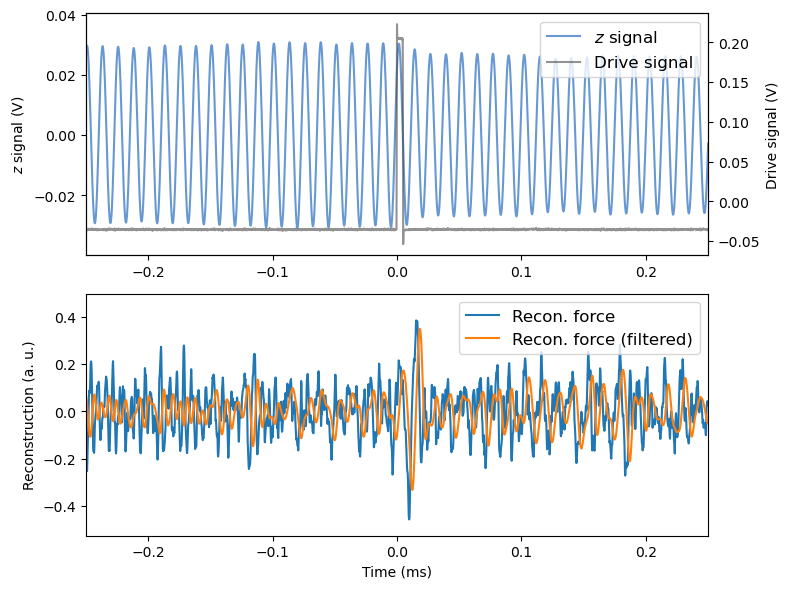

In [45]:
idx = pulse_idx[4]
_, _, _, _ = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, True, None)

In [6]:
folder = r'/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/'
dataset = r'20240802_10v_4e-8mbar'

In [7]:
combined_path = os.path.join(folder, dataset, '**/*.mat')
data_files = glob.glob(combined_path)

In [35]:
amp_all, amp_noise_all = [], []
for file in data_files:
    print(file)
    dtt, tt, nn = utils.load_timestreams(file, ['D', 'G'])
    zz, dd = nn[0], nn[1]
    fs = int(np.ceil(1/dtt))
    zz_bp = utils.bandpass_filtered(zz, fs, 40000, 130000)
    
    trigger_val = 0.1
    pulse_idx = utils.get_pulse_idx(dd, trigger_val)
    noise_idx = (0.5 * (pulse_idx[:-1] + pulse_idx[1:])).astype(np.int64)
    
    amp = np.empty(pulse_idx.size)
    amp_noise = np.empty(noise_idx.size)
    for i, idx in enumerate(pulse_idx):
        if idx < 2500 or idx > (10000000-2500):
            continue
        try:
            _, _, _, amp[i] = utils.recon_pulse(idx, dtt, tt, zz_bp, dd, False)
            _, _, _, amp_noise[i] = utils.recon_pulse(noise_idx[i], dtt, tt, zz_bp, dd, False)
        except:
            continue
    amp_all.append(amp)
    amp_noise_all.append(amp_noise)
    
amp_all = np.asarray(amp_all).ravel()
amp_noise_all = np.asarray(amp_noise_all).ravel()

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0001/20240802-0001_4.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.87261e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.47225e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.94831e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.26686e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.01222e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0001/20240802-0001_1.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.41034e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.95269e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.87859e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.31856e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.0064e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0001/20240802-0001_2.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.78805e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.05458e-31): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.56473e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.80588e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.19708e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0001/20240802-0001_3.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.30967e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.83206e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.87112e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.24038e-31): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.84236e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0005/20240802-0005_3.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.13885e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.52693e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.89885e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.19831e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.98315e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0005/20240802-0005_2.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.49154e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.56294e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.42978e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.11706e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.39048e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0005/20240802-0005_1.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.85749e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.69794e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.81923e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.29063e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.88701e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0005/20240802-0005_4.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.78103e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=8.32795e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.62689e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.21398e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.58066e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0002/20240802-0002_4.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.65097e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.12183e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.15709e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.79196e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.42491e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0002/20240802-0002_1.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.40895e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.52405e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.11815e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.18925e-31): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.95901e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0002/20240802-0002_3.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.3857e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.70023e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.47034e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.37644e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.141e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.7

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0002/20240802-0002_2.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.65146e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.37761e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.75331e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.88899e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.84775e-32): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0003/20240802-0003_4.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.28552e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.38679e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.36263e-37): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.114e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.85048e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0003/20240802-0003_3.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.94038e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.95844e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.01934e-37): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.17674e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.77421e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0003/20240802-0003_2.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.09856e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.73563e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.77033e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=8.26189e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.58617e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0003/20240802-0003_1.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.09248e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.66223e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.73781e-37): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.12981e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.12583e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0004/20240802-0004_1.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.10155e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.58772e-39): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.01427e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.02071e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.09271e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0004/20240802-0004_3.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.60741e-33): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.41465e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=3.13964e-37): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=5.27904e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.38846e-35): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0004/20240802-0004_2.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=7.86357e-41): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=4.80333e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.74434e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=6.95553e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.97582e-36): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

/Users/yuhan/work/nanospheres/data/20240802_plus_two_e_data/20240802_10v_4e-8mbar/20240802-0004/20240802-0004_4.mat


/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.16881e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=2.47659e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=9.42165e-39): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.29934e-38): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=1.11201e-34): result may not be accurate.
  x = solve(aa, bb)
/Users/yuhan/work/nanospheres/impulse_analysis/analysis_utils.py:142: LinAlgWarning: Ill-conditioned matrix (rcond=

In [80]:
amp_good = amp_all[np.logical_and(amp_all>0.3, amp_all<1.5)]
normalized_amp = amp_good * (4 / np.mean(amp_good))

amp_noise_good = amp_noise_all[np.logical_and(amp_noise_all>0.01, amp_noise_all<1)]
normalized_noise = amp_noise_good * (4 / np.mean(amp_good))
normalized_noise = normalized_noise - np.mean(normalized_noise)

In [94]:
np.max(normalized_noise)

1.391563941961329

In [81]:
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [97]:
bins = np.linspace(0, np.max(normalized_amp)*1.5, 50)
hh, be = np.histogram(normalized_amp, bins=bins)
bc = 0.5 * (be[1:] + be[:-1])

bins_noise = np.linspace(0, np.max(normalized_noise)*1.2, 20)
hh_noise, be_noise = np.histogram(normalized_noise, bins=bins_noise)
bc_noise = 0.5 * (be_noise[1:] + be_noise[:-1])

gp, gcov = curve_fit(gauss, bc, hh, p0=[np.max(hh), np.mean(np.abs(normalized_amp)), np.std(np.abs(normalized_amp))])

errs = np.sqrt(hh_noise)
errs[errs==0] = 1
spars = [np.max(hh_noise), np.std(np.abs(normalized_noise))]

noise_gauss = lambda x, A, sigma: gauss(x, A, 0, sigma)    
gp_noise, gcov_noise = curve_fit(noise_gauss, bc_noise, hh_noise, p0=spars, sigma=errs)

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_18255/2316470579.py:8: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gp), 'r', label=f'$\sigma$ = {gp[2]:.2f} MeV')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_18255/2316470579.py:9: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx_noise, noise_gauss(xx_noise, *gp_noise), 'c', label=f'$\sigma$ = {gp_noise[1]:.2f} MeV')


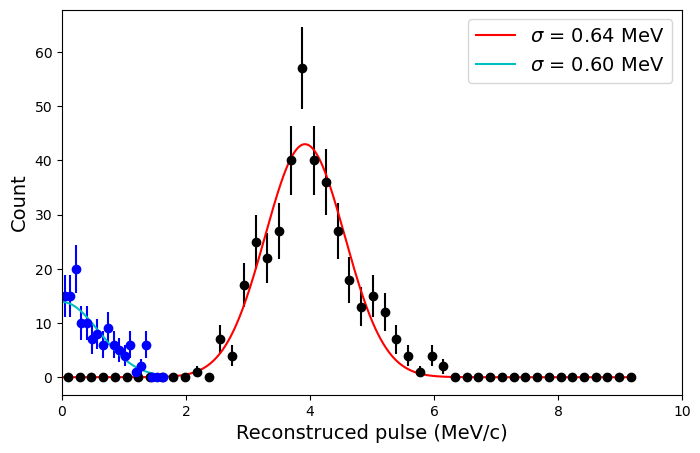

In [101]:
xx = np.linspace(0, np.max(bc), 1000)
xx_noise = np.linspace(0, np.max(bc_noise), 1000)

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='ko')
ax.errorbar(bc_noise, hh_noise, yerr=np.sqrt(hh_noise), fmt='bo')

ax.plot(xx, gauss(xx, *gp), 'r', label=f'$\sigma$ = {gp[2]:.2f} MeV')
ax.plot(xx_noise, noise_gauss(xx_noise, *gp_noise), 'c', label=f'$\sigma$ = {gp_noise[1]:.2f} MeV')
ax.set_xlabel('Reconstruced pulse (MeV/c)', fontsize=14)

ax.set_ylabel('Count', fontsize=14)

ax.set_xlim(0, 10)
ax.legend(fontsize=14)